# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [13]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


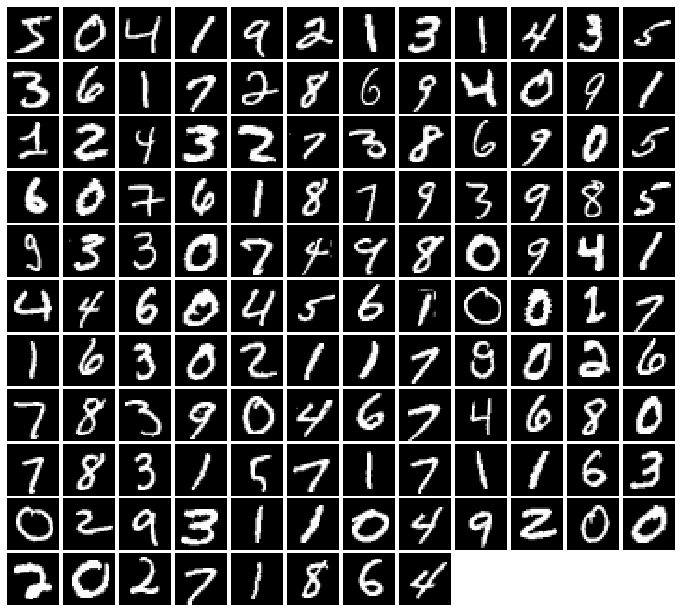

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.size(0) # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 0.7405, G:0.6829


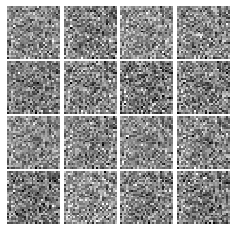


Iter: 250, D: 0.671, G:1.724


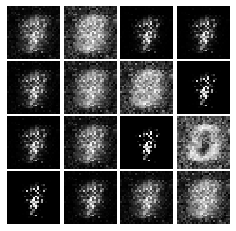


EPOCH:  2
Iter: 500, D: 0.5594, G:0.4862


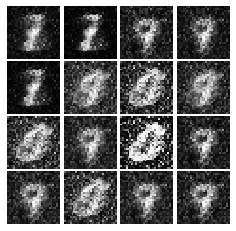


Iter: 750, D: 0.4918, G:1.468


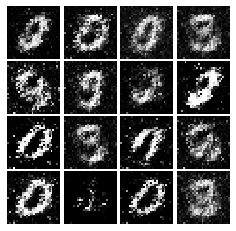


EPOCH:  3
Iter: 1000, D: 0.5743, G:1.044


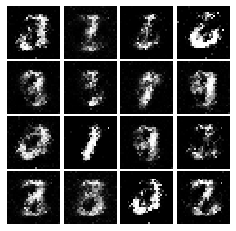


Iter: 1250, D: 0.5349, G:1.147


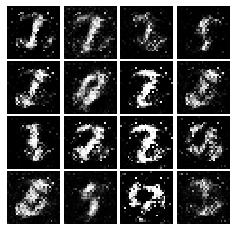


EPOCH:  4
Iter: 1500, D: 0.6162, G:1.263


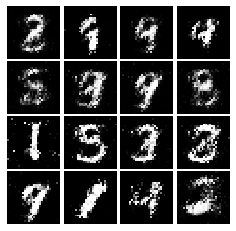


Iter: 1750, D: 0.6086, G:0.9713


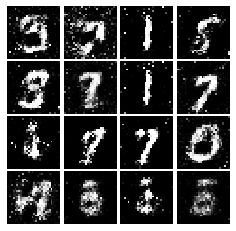


EPOCH:  5
Iter: 2000, D: 0.5814, G:1.029


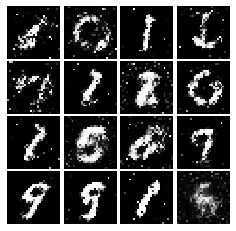


Iter: 2250, D: 0.5848, G:0.9129


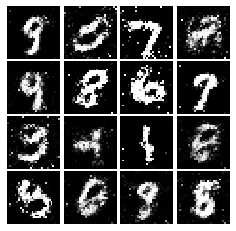


EPOCH:  6
Iter: 2500, D: 0.6432, G:0.8842


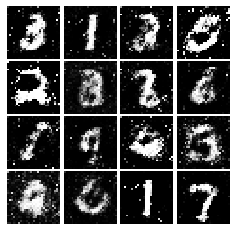


Iter: 2750, D: 0.6472, G:0.891


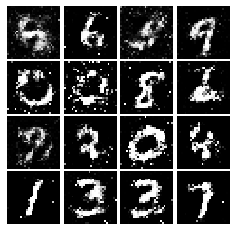


EPOCH:  7
Iter: 3000, D: 0.6607, G:0.8599


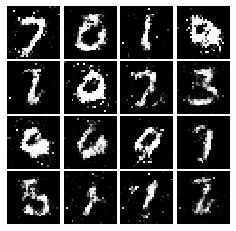


Iter: 3250, D: 0.6489, G:0.9793


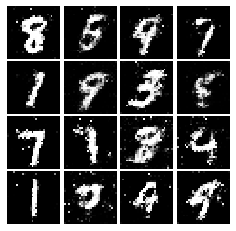


EPOCH:  8
Iter: 3500, D: 0.6197, G:0.9328


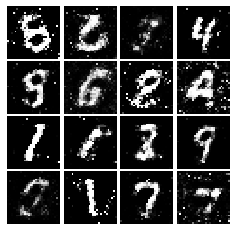


EPOCH:  9
Iter: 3750, D: 0.6684, G:0.8195


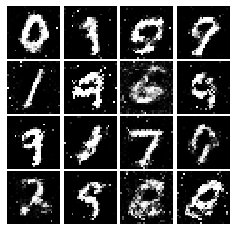


Iter: 4000, D: 0.6749, G:0.8645


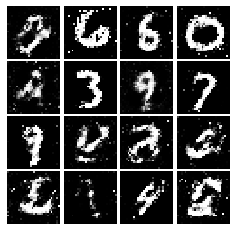


EPOCH:  10
Iter: 4250, D: 0.6702, G:0.9423


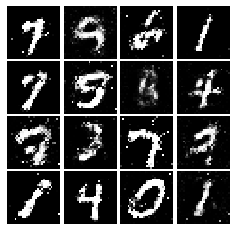


Iter: 4500, D: 0.6283, G:0.9053


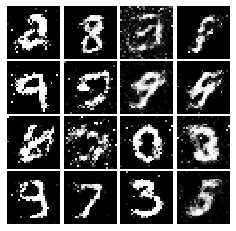

In [12]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5656, G:0.9647


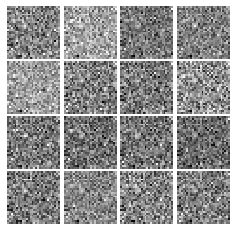


Iter: 250, D: 0.1584, G:0.5237


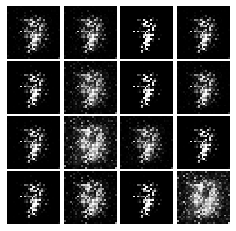


EPOCH:  2
Iter: 500, D: 0.1334, G:0.7178


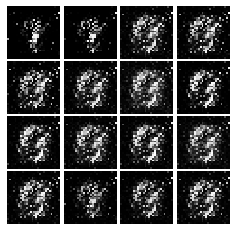


Iter: 750, D: 0.2061, G:0.5075


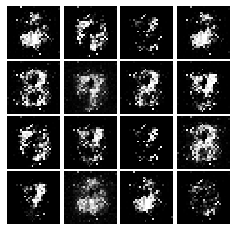


EPOCH:  3
Iter: 1000, D: 0.163, G:0.4284


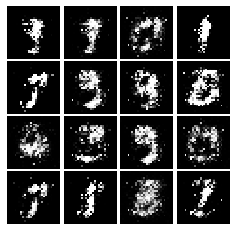


Iter: 1250, D: 0.1801, G:0.2484


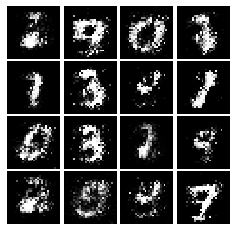


EPOCH:  4
Iter: 1500, D: 0.2154, G:0.3523


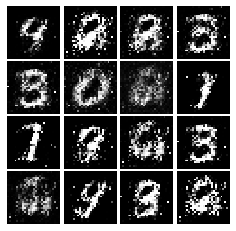


Iter: 1750, D: 0.1885, G:0.4074


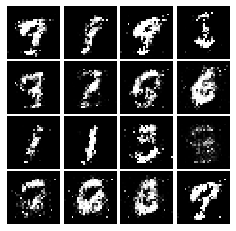


EPOCH:  5
Iter: 2000, D: 0.2484, G:0.3249


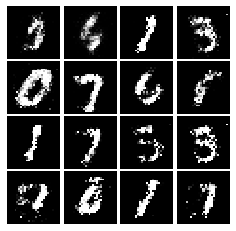


Iter: 2250, D: 0.1754, G:0.6683


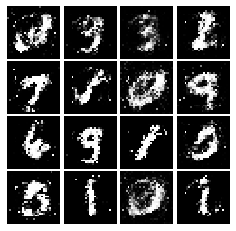


EPOCH:  6
Iter: 2500, D: 0.2502, G:0.4328


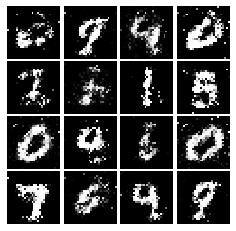


Iter: 2750, D: 0.2364, G:0.4001


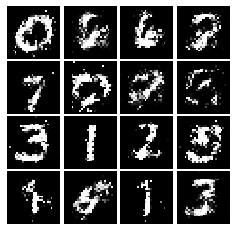


EPOCH:  7
Iter: 3000, D: 0.2102, G:0.3532


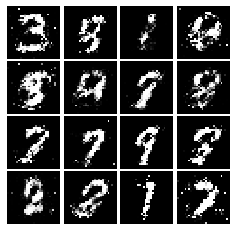


Iter: 3250, D: 0.2106, G:0.3366


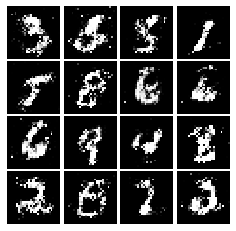


EPOCH:  8
Iter: 3500, D: 0.2281, G:0.3729


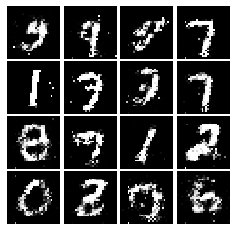


EPOCH:  9
Iter: 3750, D: 0.2261, G:0.3406


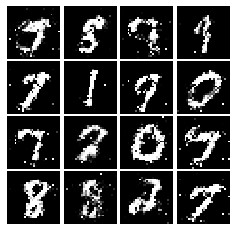


Iter: 4000, D: 0.2384, G:0.2888


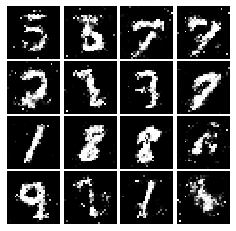


EPOCH:  10
Iter: 4250, D: 0.2264, G:0.3282


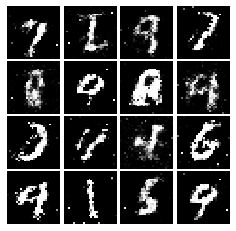


Iter: 4500, D: 0.2348, G:0.321


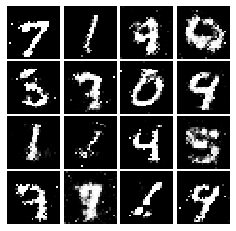

In [14]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)